# PINN: Physics-Informed Neural Network

## Solve
$$ \frac{d^2u(x)}{dx^2} = f(x) $$
$f(x)$: Given function  
$u(0)=u_0$, $u(1)=u_1$: Given boundary condition


### PINNの戦略
- ニューラルネットワークを用いて関数 $u(x)$ を表す。有限個の数値（ニューラルネットワークのハイパーパラメータ $\theta$ ）を用いて表せる連続関数（連続関数全体の一部分）で $u(x)$ を近似的に表現した。
- 様々な位置 ( collocation points $x_\mathrm{col}$ ) で $d^2u(x)/dx^2$ を評価し、与えられた$f(x)$ と一致するか確認。ずれの大きさを $\mathrm{L}(\theta)$ として定義。
- このずれ $\mathrm{L}(\theta)$ が最小（理想的には完全に0。とはいえ、用意したニューラルネットワークで表現できる関数は限られているので、その限られた関数表現の中でなるべく方程式を満たすよう努力）となる $\theta$ が得られれば、その $\theta$ で表されるニューラルネットワークが解 $u(x)$ の良い近似。

In [1]:
# ----------------------------
# 必要なライブラリのインポート
# ----------------------------
import jax                         # JAX: 高速な数値計算・自動微分・JITコンパイルを提供するライブラリ
import jax.numpy as jnp            # JAX版NumPy: GPU/TPU対応の数値計算モジュール
from flax import nnx               # Flax NNX: JAX向けのニューラルネットワーク構築ライブラリ
import optax                       # Optax: JAX向けの最適化アルゴリズム（SGD, Adamなど）を提供するライブラリ
import matplotlib.pyplot as plt    # Matplotlib: グラフ描画ライブラリ（可視化に使用）
from scipy.stats.qmc import Sobol  # Sobol列: 準乱数系列（均一な点配置に使える）
from time import time as timer     # 時間計測関数（処理時間測定）

# ----------------------------
# ニューラルネットワークモデルの定義(MLP: 多層パーセプトロン)
# ----------------------------
class MLP(nnx.Module):
    def __init__(self, *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(in_features=1, out_features=64, rngs=rngs)  # 1次元入力ベクトル → 64
        self.linear2 = nnx.Linear(in_features=64, out_features=64, rngs=rngs) # 64 → 64
        self.linear3 = nnx.Linear(in_features=64, out_features=1, rngs=rngs)  # 64 → 1次元出力ベクトル

    def __call__(self, x):            # x: (N, D) ... D 次元ベクトルを N セット入力
        x = nnx.tanh(self.linear1(x)) # 全結合線形変換の後、tanh活性化関数を施す
        x = nnx.tanh(self.linear2(x)) # 全結合線形変換の後、tanh活性化関数を施す
        x = self.linear3(x)           # 最終層は全結合線形変換のみ
        return x                      # x: (N, K) ... K 次元ベクトルを N セット出力

# ----------------------------
# PINN Poisson方程式 ソルバークラス
# ----------------------------
class PINN_Poisson():
    def __init__(self, nn_model: nnx.Module, lr: float = 1e-3):
        self.nn_model = nn_model # ニューラルネットワークモデル
        self.optimizer = nnx.Optimizer(self.nn_model, optax.adam(lr)) # 最適化器 (Adam)
        self.metrics = nnx.metrics.Average('loss') # 損失関数値を追跡するメトリクス

    # ニューラルネットワークの学習（モデル更新）
    def train(self, x_col, f_col, x_obs, u_obs, n_epochs=1500):
        for epoch in range(n_epochs + 1):
            jit_train_step(self.nn_model, self.optimizer, self.metrics, x_col, f_col, x_obs, u_obs)
            if epoch % (n_epochs // 10) == 0:
                print(f"[Epoch {epoch}] loss={self.metrics.compute()}")

    # 学習済みモデルを使って予測
    def predict(self, x):
        return self.nn_model(x)[:, 0]

# ----------------------------
# 学習ステップの定義
#    Just-in-time (JIT)コンパイルによる高速化のため、外部関数として定義
# ----------------------------
@nnx.jit
def jit_train_step(model: nnx.Module, optimizer: nnx.Optimizer, metrics: nnx.metrics.Average,
                   x_col, f_col, x_obs, u_obs):
  
    def loss_fn(m: nnx.Module):
        # --- PDE項（Poisson方程式の残差） ---
        def u_fn(x_scalar):
            return m(jnp.array(x_scalar).reshape(1,1))[0,0]
        dudx_fn = jax.grad(u_fn, argnums=0)
        d2udx2_fn = jax.jacfwd(dudx_fn, argnums=0)
        res = jax.vmap(d2udx2_fn)(x_col)[:,0,0] - f_col[:,0] # Poisson方程式残差項：d²u/dx² - f(x)
        loss_pde = jnp.mean(res**2) # PDE損失（平均二乗誤差）
        
        # --- データ項（観測値とNN出力の誤差） ---
        u_pred = m(x_obs)[:, 0]                # 観測点におけるNN出力（shape: (N_obs,)）
        loss_data = jnp.mean((u_pred - u_obs)**2) # データ損失（平均二乗誤差）
        
        # --- 全体損失（同等重みで和を取る） ---
        return loss_pde + loss_data
        
    loss, grads = nnx.value_and_grad(loss_fn)(model) # 損失とその勾配を計算
    optimizer.update(grads)   # オプティマイザに勾配を渡し、NNモデルパラメータを上書き更新
    metrics.update(loss=loss) # 損失を記録
    return

[Epoch 0] loss=0.4168594479560852
[Epoch 150] loss=0.018533695489168167
[Epoch 300] loss=0.010277236811816692
[Epoch 450] loss=0.007261085323989391
[Epoch 600] loss=0.005664869677275419
[Epoch 750] loss=0.004660888109356165
[Epoch 900] loss=0.003963855095207691
[Epoch 1050] loss=0.0034489608369767666
[Epoch 1200] loss=0.003051856067031622
[Epoch 1350] loss=0.00273547088727355
[Epoch 1500] loss=0.0024768926668912172
Elapsed time [sec] = 1.2621874809265137


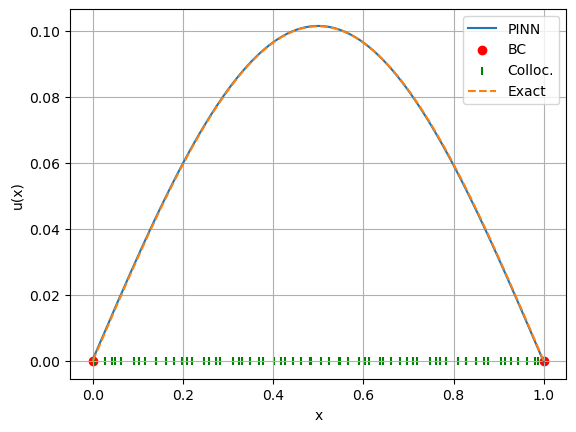

In [2]:
# ----------------------------
# メイン実行ブロック
# ----------------------------

# --- 問題定義 ---
D = 1  # 入力の次元数（ここでは1次元のPoisson方程式を対象）
f_fn = lambda x: -jnp.sin(jnp.pi * x[:, 0]) # 右辺関数 f(x)（JAX配列対応）
x_obs = jnp.array([[0.0], [1.0]])  # 観測点 x（境界条件などに対応）
u_obs = jnp.array([0.0, 0.0])      # 観測値 u(x)（境界値など）

# --- PDE評価位置 (Collocation points) の選定 ---
sampler = Sobol(d=D, scramble=True, seed=0)  # Sobol点列（低偏差系列）でほぼ均質な乱数配置
x_col = jnp.array(sampler.random_base2(m=6)) # 2^6 = 64個のCollocation
f_col = f_fn(x_col).reshape(-1, 1)           # f(x)をCollocation点で評価（(64,1)

# --- PINN学習 ---
nn_model = MLP(rngs=nnx.Rngs(0))     # ニューラルネットワークの初期化
pinn_solver = PINN_Poisson(nn_model) # PINNソルバーインスタンスを作成
t0 = timer()
pinn_solver.train(x_col, f_col, x_obs, u_obs, n_epochs=1500) # 上記問題に対して学習実行
t1 = timer(); print("Elapsed time [sec] =", t1 - t0)

# --- 予測と可視化 ---
x_plot = jnp.linspace(0, 1, 200).reshape(-1, D) # 可視化用の均等点（200点）
u_pred = pinn_solver.predict(x_plot)            # 学習済みモデルで予測

u_exact = lambda x: jnp.sin(jnp.pi * x[:, 0]) / (jnp.pi**2) # 結果比較用の解析解

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_plot[:, 0], u_pred, label="PINN")
ax.scatter(x_obs[:, 0], u_obs, c="red", label="BC")
ax.scatter(x_col[:, 0], jnp.zeros_like(x_col[:, 0]), marker="|", c="green", label="Colloc.")
ax.plot(x_plot[:, 0], u_exact(x_plot), '--', label="Exact")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend()
ax.grid()
plt.show()

[Epoch 0] loss=1.414275050163269
[Epoch 250] loss=0.1373259723186493
[Epoch 500] loss=0.08077804744243622
[Epoch 750] loss=0.054633092135190964
[Epoch 1000] loss=0.04128221422433853
[Epoch 1250] loss=0.03317209333181381
[Epoch 1500] loss=0.027713362127542496
[Epoch 1750] loss=0.023802245035767555
[Epoch 2000] loss=0.020854538306593895
[Epoch 2250] loss=0.01856033317744732
[Epoch 2500] loss=0.01672656089067459
Elapsed time [sec] = 1.864694356918335


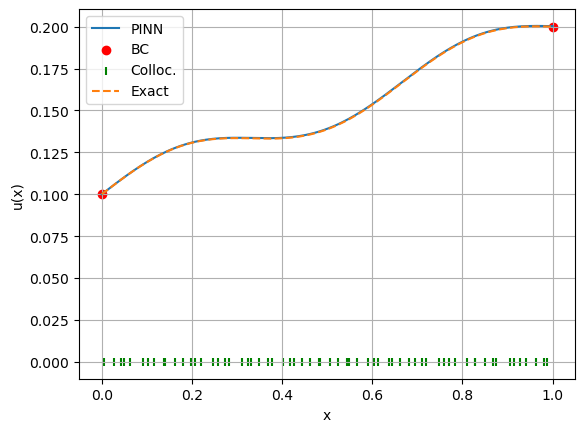

In [3]:
# ----------------------------
# 別の f(x) や u(0), u(1) の問題設定についても適用してみる
# ----------------------------

# --- 問題定義 ---
D = 1  # 入力の次元数（ここでは1次元のPoisson方程式を対象）
f_fn = lambda x: -jnp.sin(3 * jnp.pi * x[:, 0]) # 右辺関数 f(x)（JAX配列対応）
x_obs = jnp.array([[0.0], [1.0]])  # 観測点 x（境界条件などに対応）
u_obs = jnp.array([0.1, 0.2])      # 観測値 u(x)（境界値など）

# --- PDE評価位置 (Collocation points) の選定 ---
sampler = Sobol(d=D, scramble=True, seed=0)  # Sobol点列（低偏差系列）でほぼ均質な乱数配置
x_col = jnp.array(sampler.random_base2(m=6)) # 2^6 = 64個のCollocation
f_col = f_fn(x_col).reshape(-1, 1)           # f(x)をCollocation点で評価（(64,1)

# --- PINN学習 ---
nn_model = MLP(rngs=nnx.Rngs(0))     # ニューラルネットワークの初期化
pinn_solver = PINN_Poisson(nn_model) # PINNソルバーインスタンスを作成
t0 = timer()
pinn_solver.train(x_col, f_col, x_obs, u_obs, n_epochs=2500) # 上記問題に対して学習実行
t1 = timer(); print("Elapsed time [sec] =", t1 - t0)

# --- 予測と可視化 ---
x_plot = jnp.linspace(0, 1, 200).reshape(-1, D) # 可視化用の均等点（200点）
u_pred = pinn_solver.predict(x_plot)            # 学習済みモデルで予測

u_exact = lambda x: jnp.sin(3*jnp.pi * x[:, 0]) / ((3*jnp.pi) ** 2) + 0.1 + 0.1*x[:,0] # 結果比較用の解析解

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_plot[:, 0], u_pred, label="PINN")
ax.scatter(x_obs[:, 0], u_obs, c="red", label="BC")
ax.scatter(x_col[:, 0], jnp.zeros_like(x_col[:, 0]), marker="|", c="green", label="Colloc.")
ax.plot(x_plot[:, 0], u_exact(x_plot), '--', label="Exact")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend()
ax.grid()
plt.show()